In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scienceplots

In [2]:
res_path = "./../results"

res = pd.read_csv(f"{res_path}/case1_h22_d9.csv")
res = res.iloc[1:600]

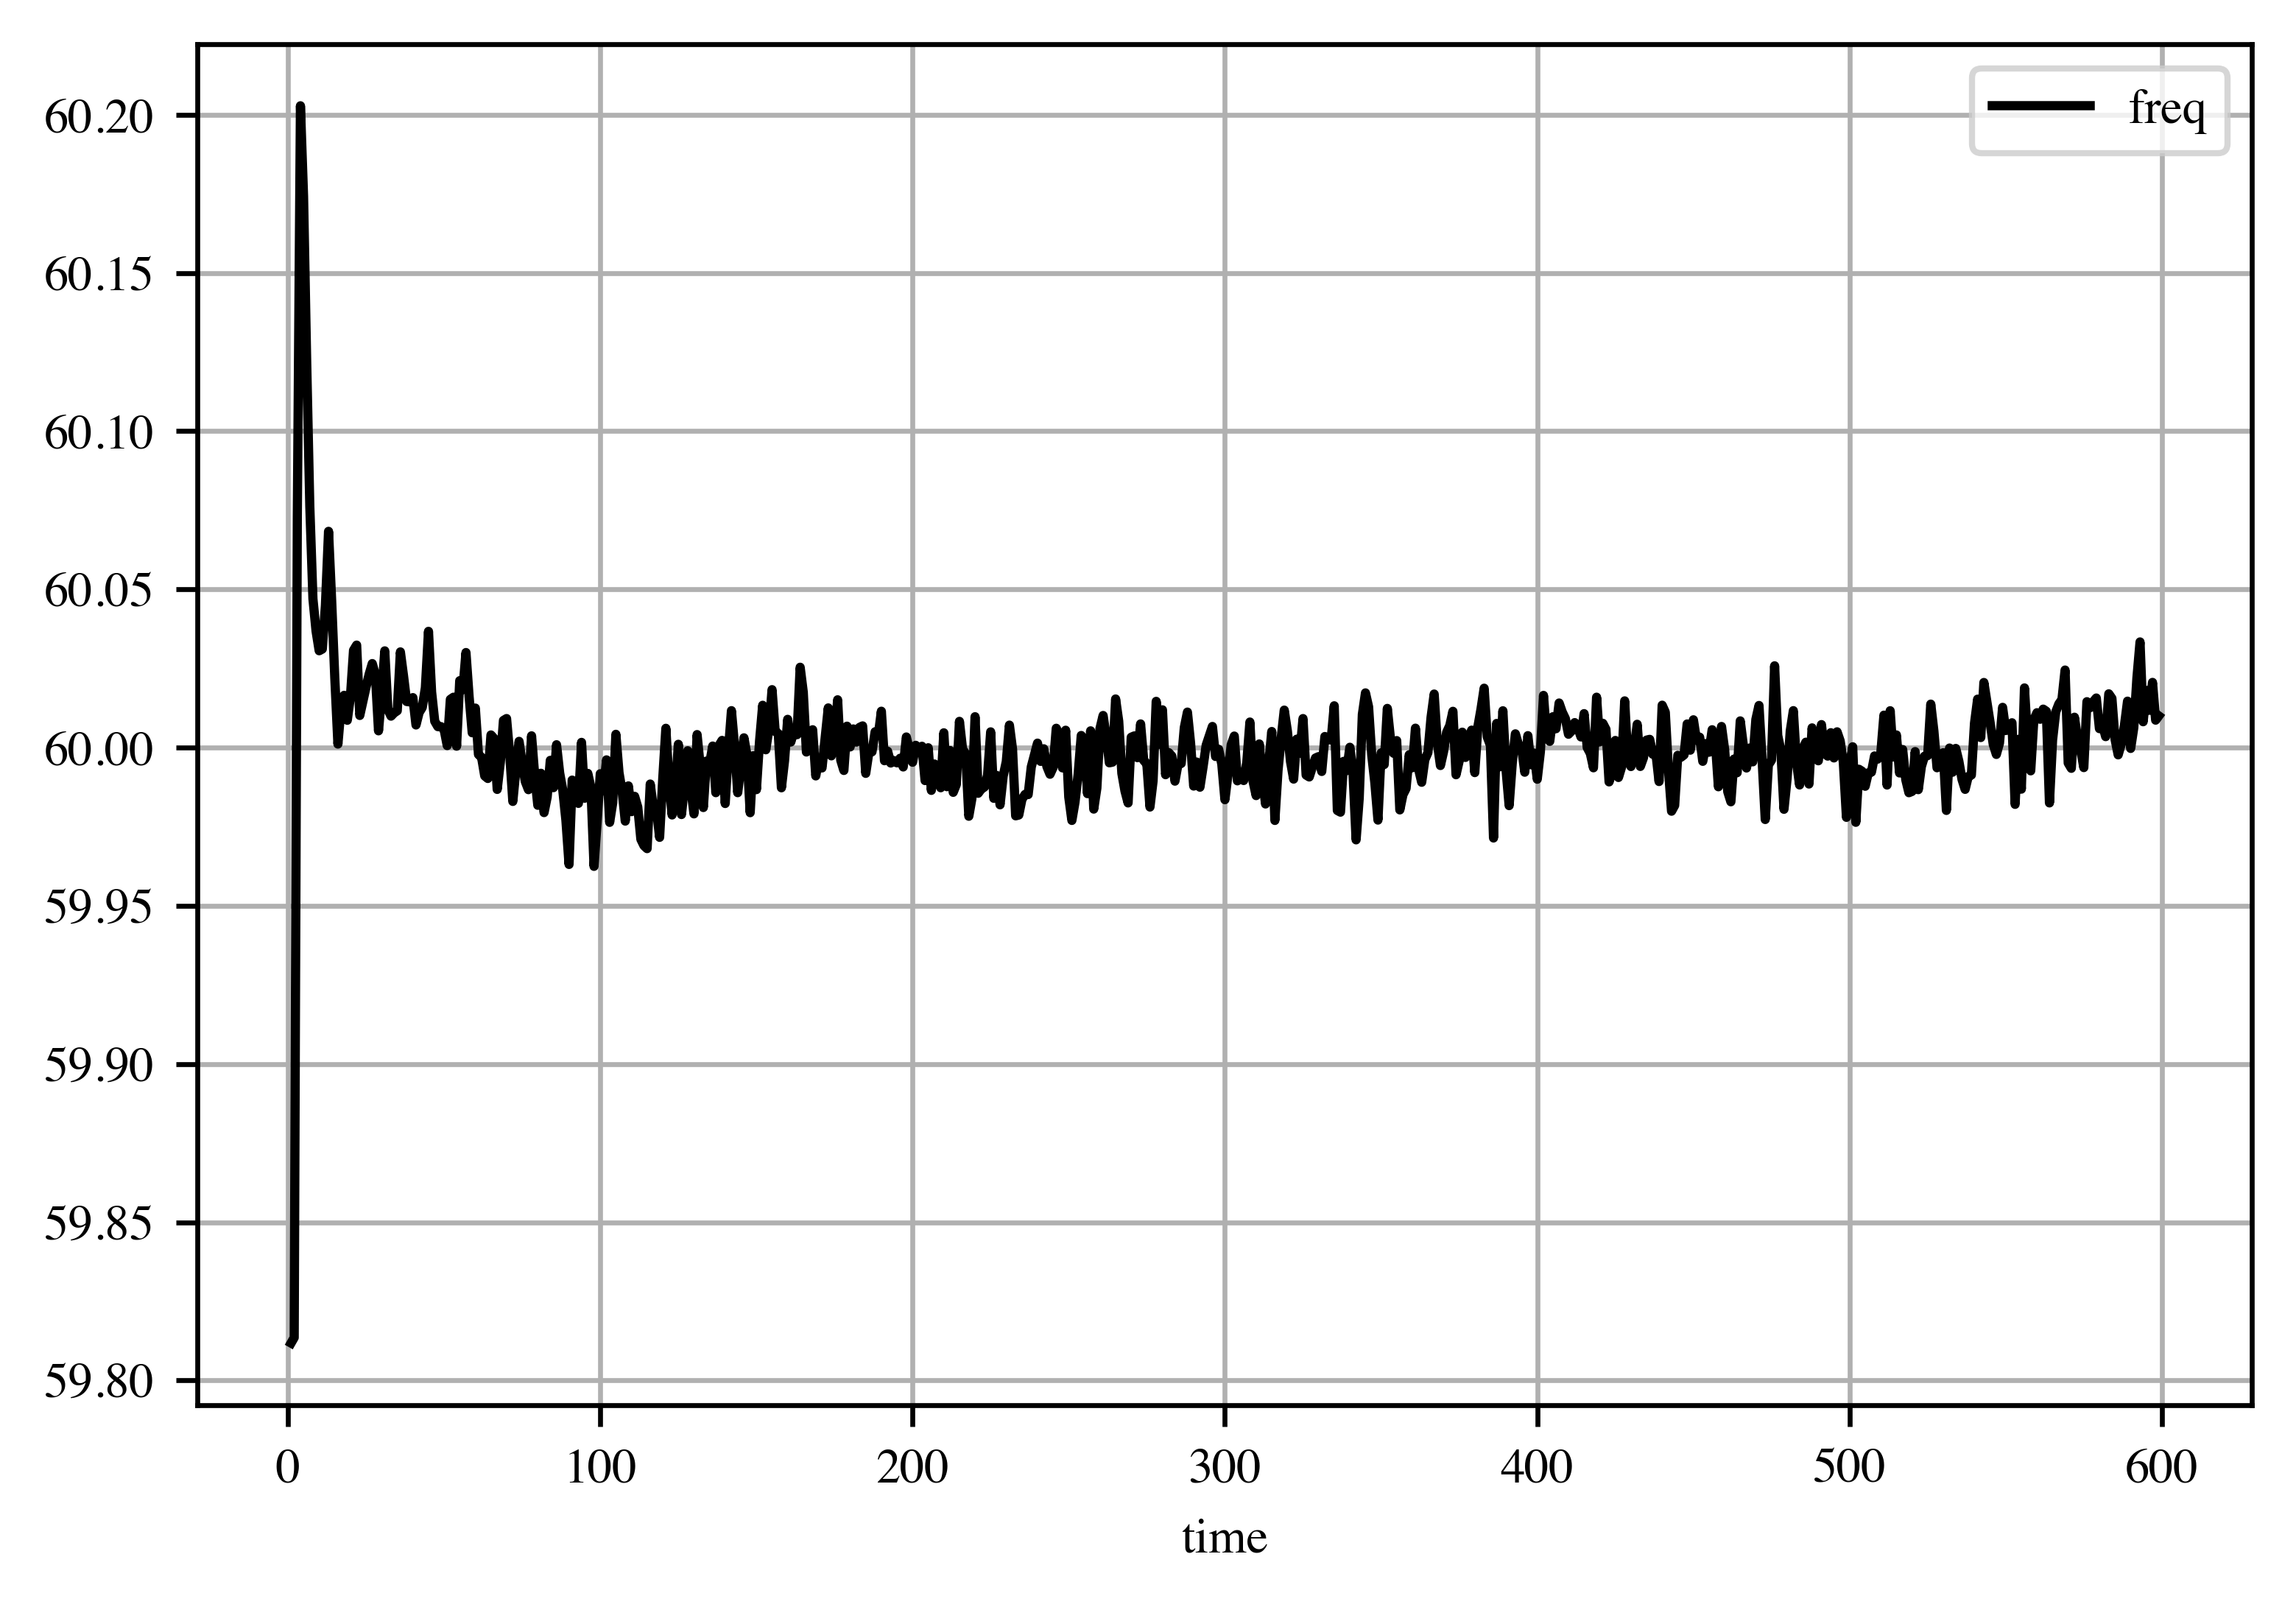

In [3]:
plt.style.use(["default", "ieee"])
ax = res.plot(x="time",
              y=["freq"],
              figsize=(6, 4),
            #   xlim=(0,),
              grid=True,)